# Imports

In [1]:
# Dynamic
%matplotlib notebook
# Standard
# %matplotlib inline

from os.path import join, isdir, basename
from glob import iglob
import sys
import json
import pickle
import pandas
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import draw_learning_curve

# Allow to import the modules in the model folder
sys.path.append('../model/')

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 8

# path of the folder with the results
res_path = '../model/res/'

# Functions

In [2]:
def split_seeds_and_sims(cluster_sim_path, param_filter=[]):
    """
    - cluster_sim_path:  name of the folder with all the results
    - param_filter: list of filters. Each filter contains the accepted values
    for one type of parameter in the name of the sub-folder in cluster_sim_path
    """
    run_paths = sorted([run_path for run_path in iglob(join(cluster_sim_path, '*')) if isdir(run_path)])
    options_list = []
    seeds = set()
    sims = set()
    
    for path in run_paths:
        options = basename(path).split("+", 1)
        for i, option in enumerate(options):
            if i == 0:
                seeds.add(option)
            else:
                is_ok = True
                for filters in param_filter:
                    find_one = False
                    for f in filters:
                        if f in option:
                            find_one = True
                            break
                    if not find_one:
                        is_ok = False
                        break
                if is_ok:
                    sims.add(option)

    seeds = sorted(list(seeds))
    sims = natsorted(list(sims))
    print("seeds =", seeds)
    print("sims =", sims)
    print("number of simulations:", len(sims))
    print("number of seeds per simulation:", len(seeds))
    
    return seeds, sims

In [18]:
def extract_data(cluster_sim_path, seeds, sims, nb_days):
    label_names = []  # labels for the legend of the plot
    final_scores = []
    mean_scores = np.zeros((len(sims), nb_days*2))  # nb_days*2: day morning + day evening
    # 1 line = 1 parameter set ; 1 column = mean number of gestures in a song for this day
    mean_nb_gest = np.zeros((len(sims), nb_days))
    
    for i, sim in enumerate(sims):
        sim_mean_score = None
        
        # for each day, store the sum of the number of gestures of the songs
        sim_sum_nb_gest = np.zeros(nb_days)
        
        for seed in seeds:
            sim_name = '+'.join([seed, sim])
            path = cluster_sim_path + sim_name
            
            try:
                with open(join(path, 'data.pkl'), 'rb') as f:
                    songlog = pickle.load(f)
            except FileNotFoundError:
                print(FileNotFoundError)
                continue
                
            root_data = [item[1] for item in songlog if item[0] == 'root']
            rd = pandas.DataFrame(root_data)
            # score_array shape: nb_day_song x nb_days*2
            score_array = np.array([list(rd['scores'].iloc[i_day]) for i_day in range(nb_days*2)]).T

            # -- Store the values for each seed --
            if sim_mean_score is None:
                sim_mean_score = score_array
            else:
                sim_mean_score = np.concatenate((sim_mean_score, score_array), axis=0)
                
            # -- Accumulate the number of song's gestures per day --
            for j in range(nb_days*2):
                if j % 2 == 0:  # at day morning, after the night which has changed the number of gestures
                    sum_nb_gest = 0
                    for sm in rd['songs'].iloc[j]:
                        sum_nb_gest += len(sm.gestures)
                    sim_sum_nb_gest[j//2] += sum_nb_gest

        # sim_mean_score shape before: nb_day_song*nb_seeds x nb_days*2
        # sim_mean_score shape after: 1 x nb_days*2
        sim_mean_score = np.mean(sim_mean_score, axis=0)
        # mutliply by -1 to get a rising curve
        sim_mean_score *= -1
        # store the mean final score
        final_scores.append(round(sim_mean_score[-1], 3))
        # store the result for each parameter set
        mean_scores[i] = sim_mean_score        
        # compute the mean from the sum accumulated
        sim_sum_nb_gest /= run_param['concurrent'] * len(seeds)
        mean_nb_gest[i] = sim_sum_nb_gest.astype(int)
        """
        /!\ hard fix for specific simulations:
        shorten the name for the legend in the plot
        """
        if "dev_test" in sim:
            sim = sim.split("+")[0]
        elif "nlm_div_th_test" in sim:
            sim = sim.split("+")[2]
        elif "grid_div_th" in sim:
            val_div_th = sim.split("+")[1].split("_")[0]
            sim = "Seuil de voisinage : {}".format(val_div_th)
        elif "dlm_nlm_equilibrium" in sim:
            sim = " ".join(sim.split("+")[3:])
        elif "no_night" in sim:
            nb_split = int(mean_nb_gest[i][0])
            nb_train = sim.split("+")[2].split("_")[0]
            sim = "{} gestes, {} entrainements par jour".format(nb_split, nb_train)
        elif "long_div_th_new_params" in sim:
            val_div_th = sim.split("+")[1].split("_")[0]
            sim = "Seuil de voisinage : {}".format(val_div_th)
        # store the name of the simulation
        label_names.append(sim)
        
    return mean_scores, np.array(final_scores), mean_nb_gest, label_names

In [14]:
def plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title=None):
    """Plot the mean learning curve of one parameter set"""
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = fig.gca()
    for i in range(1, nb_steps, 2):
        ax.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
    
    #     plt.plot(mean_scores.T)  # plot all at once without using the colormap
    
    # -- without no_night results --
#     color_id = np.linspace(0, 1, len(mean_scores))
#     for i in range(len(mean_scores)):
#         plt.plot(mean_scores[i], color=plt.cm.plasma(color_id[i]))
    # ------------------------------
        
    # -- with no_night results --
    color_id_no_night = np.linspace(0, 1, 4)
    nb_learning = len(mean_scores) - 4
    color_id_learning = np.linspace(0,1, nb_learning)
    for i in range(len(mean_scores)):
        if i < nb_learning:
            c = plt.cm.plasma(color_id_learning[i])
        else:
            c = plt.cm.winter(color_id_no_night[i - nb_learning])      
        plt.plot(mean_scores[i], color=c)
    # ---------------------------
        
    plt.xticks(range(0, nb_steps+1, 2), range(0, nb_steps//2+1))
    plt.xlim(0, nb_steps)
    y_min = -20
    y_max = -5
    plt.ylim(y_min, y_max)
    plt.yticks(range(y_min, y_max+1))
    plt.xlabel("Jour")
    plt.ylabel("Distance d'erreur par rapport au tuteur")
    final_title = "Courbes d'apprentissage"
    if title is not None:
        final_title += ' ({})'.format(title)
    plt.title(final_title)
    legends = ["{}. Distance d'erreur : {}".format(label_names[i], final_scores[i]) for i in range(len(label_names))]
    plt.legend(legends)
#     plt.legend(legends, fontsize="small")
    fig.tight_layout()
    plt.show()

In [15]:
def plot_mean_number_gestures(mean_nb_gest, label_names, nb_days, title=None):
    """Plot for the mean number of gesture in a song per day"""
    x = np.tile(np.arange(nb_days), (len(mean_nb_gest), 1))
    color_id = np.linspace(0, 1, len(mean_nb_gest))
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i in range(len(mean_nb_gest)):
        plt.plot(x[i], mean_nb_gest[i],
                 color=plt.cm.plasma(color_id[i]), marker='o')
#     plt.plot(x.T, mean_nb_gest.T, marker='o')
    y_max = 110
    plt.yticks(range(0,y_max+10,10))
    plt.ylim(0, y_max)
    plt.xlabel("Days")
    plt.ylabel("Mean number of gestures")
    plt.grid()
    legends = ["{} (end: {})".format(label_names[i], mean_nb_gest[i][nb_days-1]) for i in range(len(label_names))]
    plt.legend(legends)
#     plt.legend(legends, fontsize="small")
    final_title = "Mean number of gestures in the learned songs per day of learning"
    if title is not None:
        final_title += " ({})".format(title)
    plt.title(final_title)
    fig.tight_layout()
    plt.show()

In [16]:
def plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title=None):
    """Correlation between number of gestures and final score"""
    color_id = np.linspace(0, 1, len(mean_nb_gest))
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i in range(len(mean_nb_gest)):
        plt.scatter(mean_nb_gest[i][-1], final_scores[i], color=plt.cm.plasma(color_id[i]))
    plt.grid()
    plt.xlabel("Mean number of gestures in the final songs")
    plt.ylabel("Mean scores of the final songs")
    plt.legend(label_names)
    final_title = "Relation between the number of gestures and the final score"
    if title is not None:
        final_title += " ({})".format(title)
    plt.title(final_title)
    fig.tight_layout()
    plt.show()

# Comparison long_grid_div_th_180821_183837 and no_night_180910_165800

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_grid_div_th+2500_diversity_th', 'long_grid_div_th+2750_diversity_th', 'long_grid_div_th+3000_diversity_th', 'long_grid_div_th+3250_diversity_th', 'long_grid_div_th+3750_diversity_th', 'long_grid_div_th+4500_diversity_th', 'long_grid_div_th+5000_diversity_th', 'long_grid_div_th+5500_diversity_th']
number of simulations: 8
number of seeds per simulation: 10
seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['10_split+no_night+200_train_per_day', '10_split+no_night+400_train_per_day', '80_split+no_night+200_train_per_day', '80_split+no_night+400_train_per_day']
number of simulations: 4
number of seeds per simulation: 10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


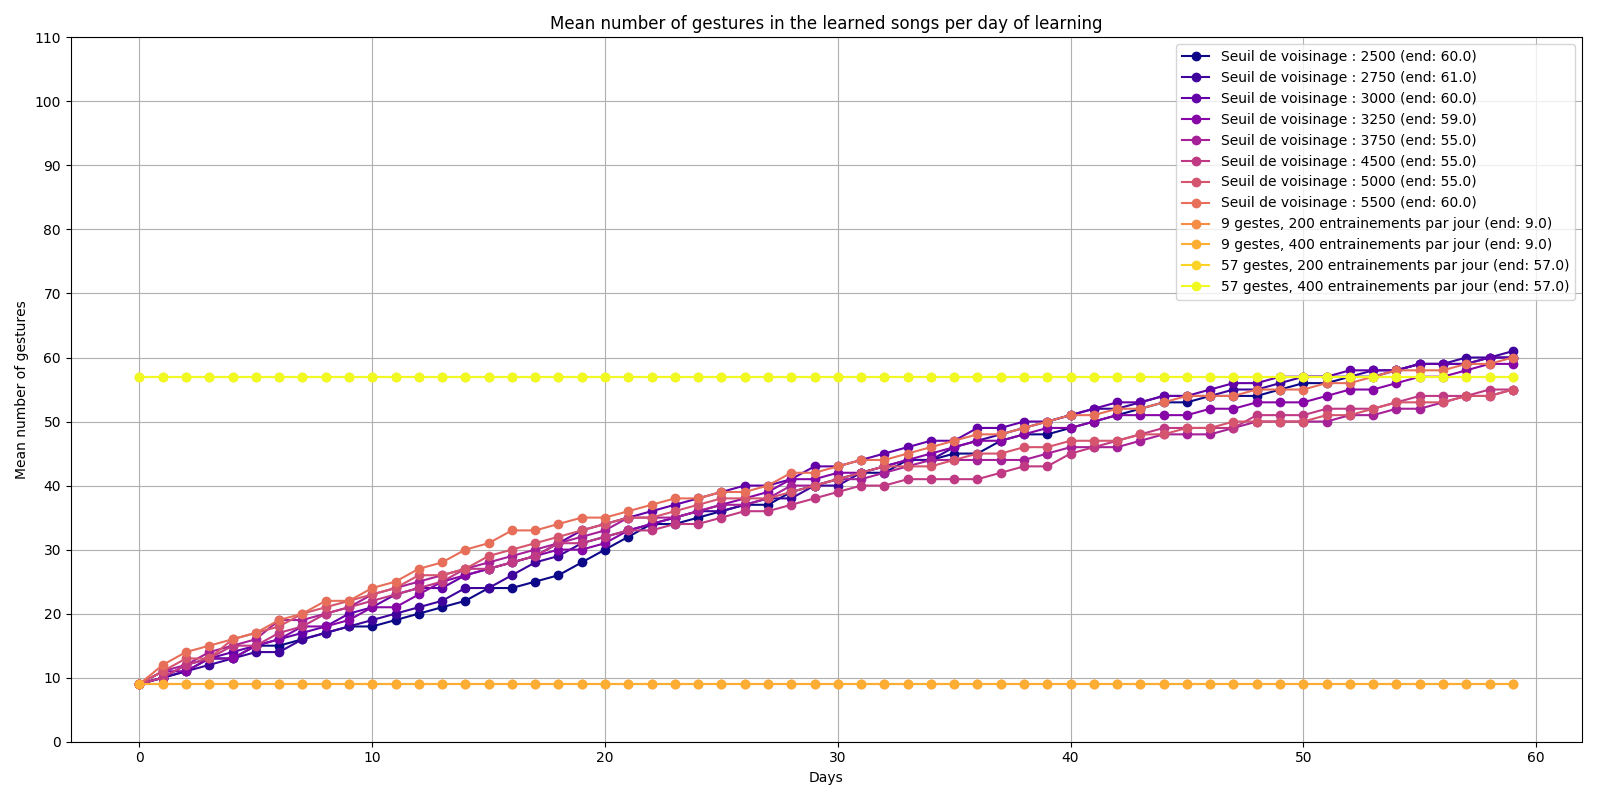

In [20]:
cluster_sim_path = res_path + 'long_grid_div_th_180821_183837/'
l_div_th = ['2500', '2750', '3000', '3250',
            '3750', '4500', '5000', '5500']  # the flattering one
param_filter = [l_div_th]
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores_div_th, final_scores_div_th, mean_nb_gest_div_th, label_names_div_th = tup

cluster_sim_path = res_path + "no_night_180910_165800/"
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores_no_night, final_scores_no_night, mean_nb_gest_no_night, label_names_no_night = tup

mean_scores = np.concatenate((mean_scores_div_th, mean_scores_no_night))
final_scores = np.concatenate((final_scores_div_th, final_scores_no_night))
mean_nb_gest = np.concatenate((mean_nb_gest_div_th, mean_nb_gest_no_night))
label_names = label_names_div_th + label_names_no_night
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps)
plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'])

# Comparison long_div_th_new_params_180917_115103 and no_night_new_params_180917_115152
- These simulations use the new model / params:
    - only  3 mutations
	- initial night population: 3 day songs + 17 mutations
	- max beta value: -0.002
	- last version of prior and dev values

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_div_th_new_params+2750_diversity_th', 'long_div_th_new_params+3000_diversity_th', 'long_div_th_new_params+3250_diversity_th', 'long_div_th_new_params+3500_diversity_th', 'long_div_th_new_params+3750_diversity_th', 'long_div_th_new_params+4000_diversity_th', 'long_div_th_new_params+4500_diversity_th', 'long_div_th_new_params+5000_diversity_th', 'long_div_th_new_params+5500_diversity_th', 'long_div_th_new_params+6000_diversity_th']
number of simulations: 10
number of seeds per simulation: 10
seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['10_split+no_night_new_params+200_train_per_day', '10_split+no_night_new_params+400_train_per_day', '80_split+no_night_new_params+200_train_per_day', '80_split+no_night_new_params+400_train_per_day']
number of simulations: 4
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


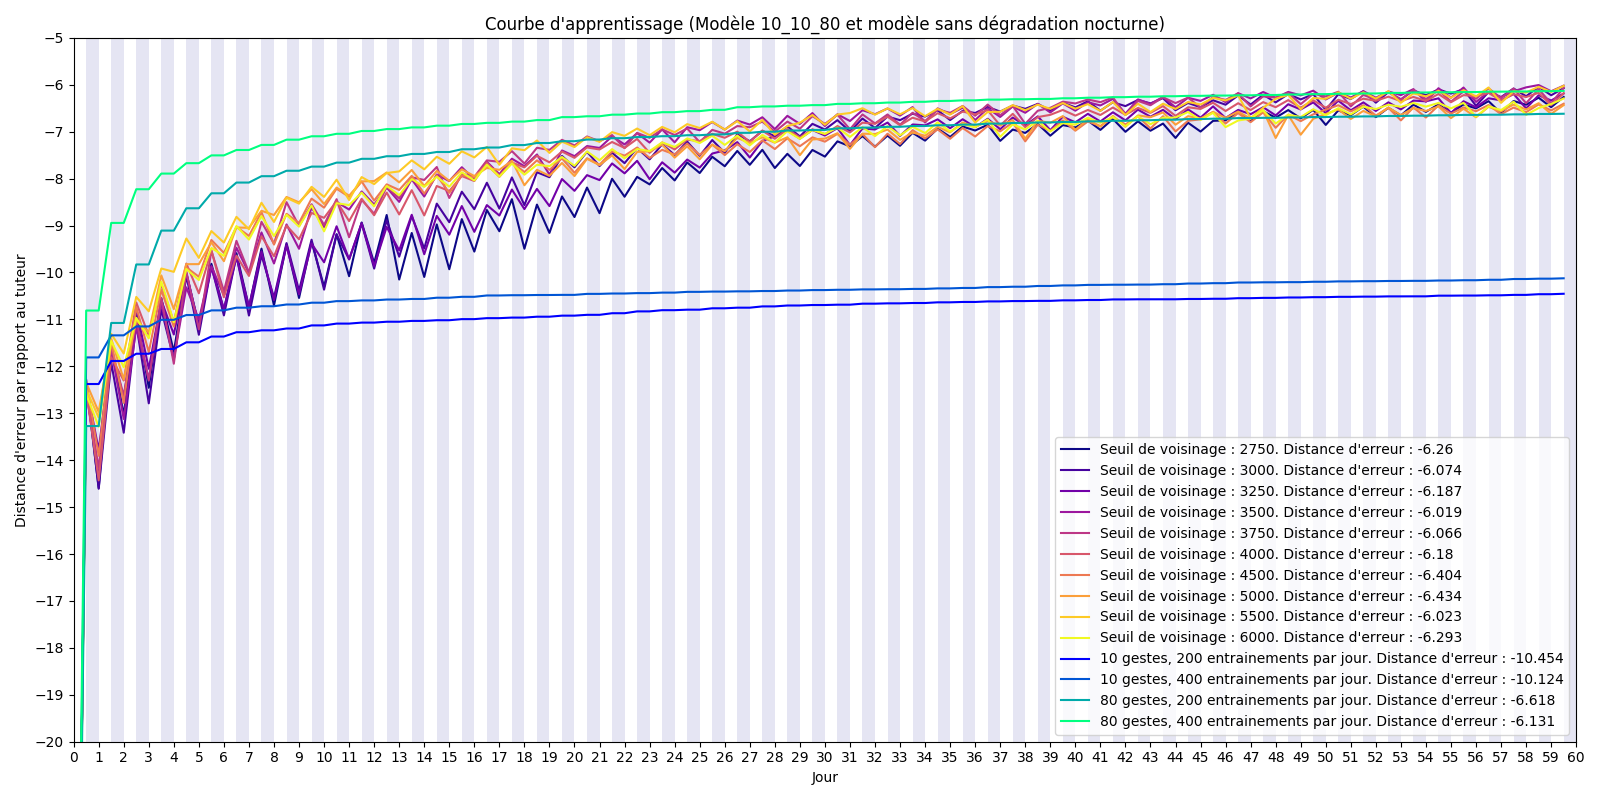

In [32]:
cluster_sim_path = res_path + 'long_div_th_new_params_180917_115103/'
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores_div_th, final_scores_div_th, mean_nb_gest_div_th, label_names_div_th = tup

cluster_sim_path = res_path + "no_night_new_params_180917_115152/"
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores_no_night, final_scores_no_night, mean_nb_gest_no_night, label_names_no_night = tup

mean_scores = np.concatenate((mean_scores_div_th, mean_scores_no_night))
final_scores = np.concatenate((final_scores_div_th, final_scores_no_night))
mean_nb_gest = np.concatenate((mean_nb_gest_div_th, mean_nb_gest_no_night))
label_names = label_names_div_th + label_names_no_night
title = "Modèle 10_10_80 et modèle sans dégradation nocturne"
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)

# long_div_th_new_params_180917_115103
- New model / params:
    - only  3 mutations
	- initial night population: 3 day songs + 17 mutations
	- max beta value: -0.002
	- last version of prior and dev values

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_div_th_new_params+2750_diversity_th', 'long_div_th_new_params+3000_diversity_th', 'long_div_th_new_params+3250_diversity_th', 'long_div_th_new_params+3500_diversity_th', 'long_div_th_new_params+3750_diversity_th', 'long_div_th_new_params+4000_diversity_th', 'long_div_th_new_params+4500_diversity_th', 'long_div_th_new_params+5000_diversity_th', 'long_div_th_new_params+5500_diversity_th', 'long_div_th_new_params+6000_diversity_th']
number of simulations: 10
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


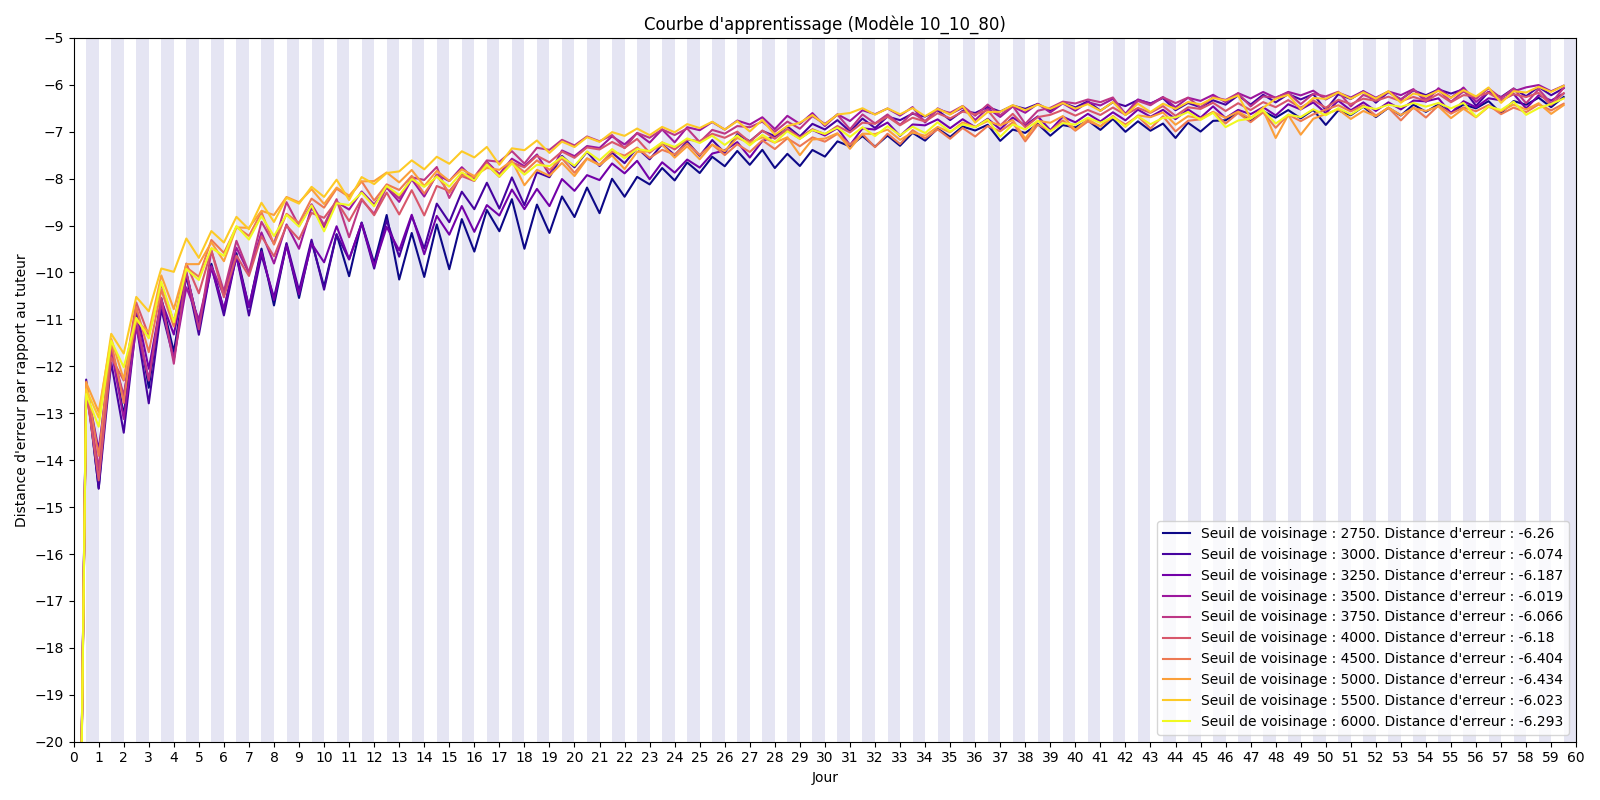

In [24]:
cluster_sim_path = res_path + 'long_div_th_new_params_180917_115103/'
param_filter = []  # no filter
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores, final_scores, mean_nb_gest, label_names = tup
title = "Modèle 10_10_80"
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# rms_optimisation_180917_113559
- during the day calculate the rms of all the points to decide if the new song is better than the current one
- but during the night still use the standard error distance using all the features as measure of quality instead of just the rms of all the point
- remark: the data saved are the error distance using all the features and not the rms of all point. But those value can be recover with the song models saved.

The plots here use the standard error calculation using all the features

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['rms_optimisation+1500_diversity_th', 'rms_optimisation+2000_diversity_th', 'rms_optimisation+2500_diversity_th', 'rms_optimisation+3000_diversity_th', 'rms_optimisation+3500_diversity_th', 'rms_optimisation+4000_diversity_th', 'rms_optimisation+4500_diversity_th', 'rms_optimisation+5000_diversity_th', 'rms_optimisation+5500_diversity_th', 'rms_optimisation+6000_diversity_th']
number of simulations: 10
number of seeds per simulation: 10


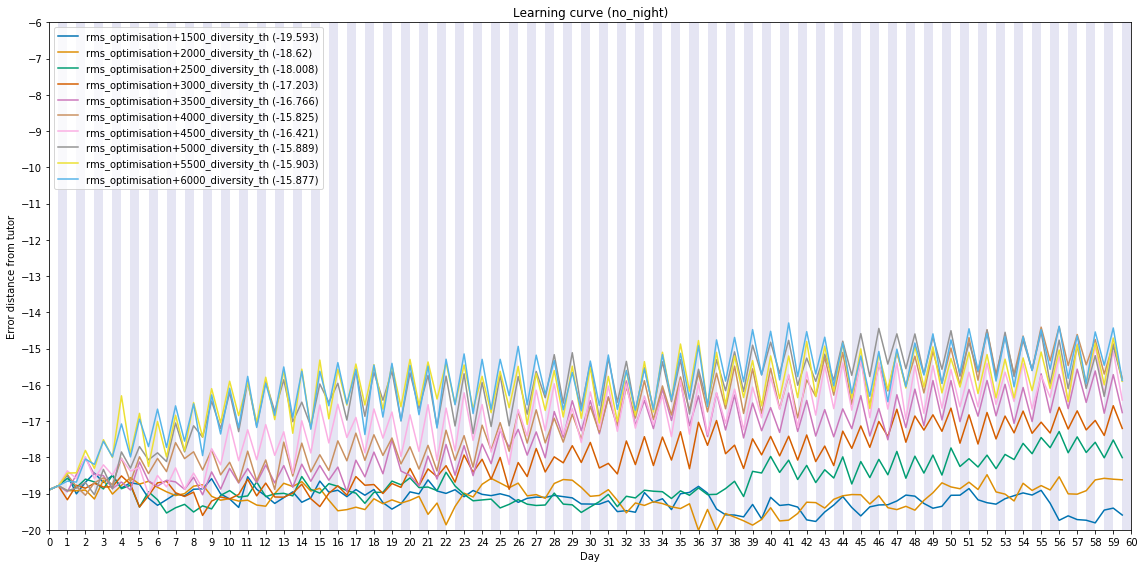

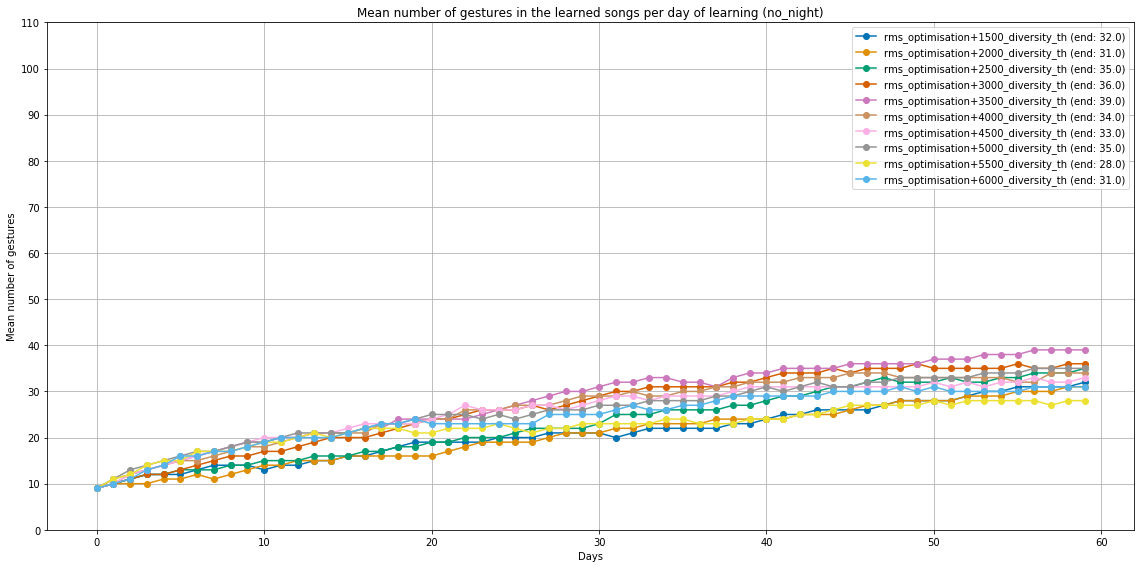

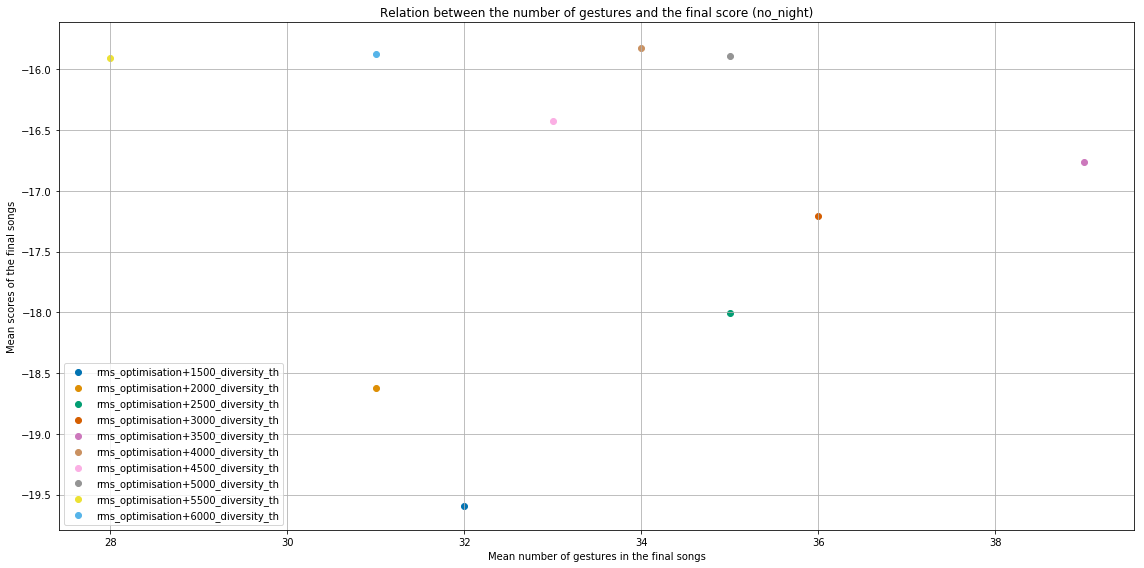

In [8]:
cluster_sim_path = res_path + "rms_optimisation_180917_113559/"
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores, final_scores, mean_nb_gest, label_names = tup
title = "rms_optimisation"
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# no_night_180910_165800

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['10_split+no_night+200_train_per_day', '10_split+no_night+400_train_per_day', '80_split+no_night+200_train_per_day', '80_split+no_night+400_train_per_day']
number of simulations: 4
number of seeds per simulation: 10


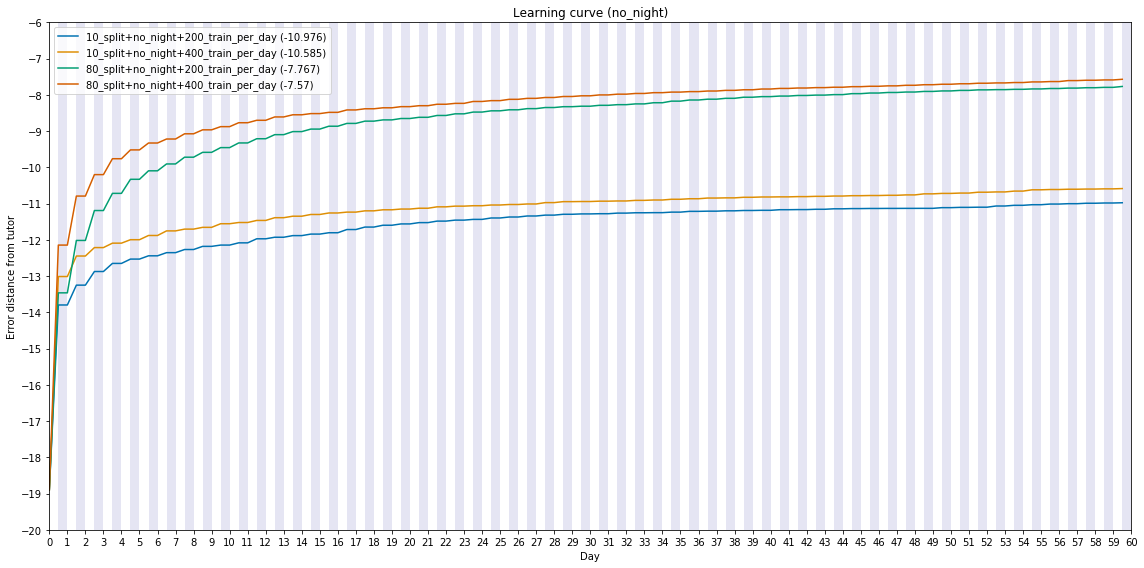

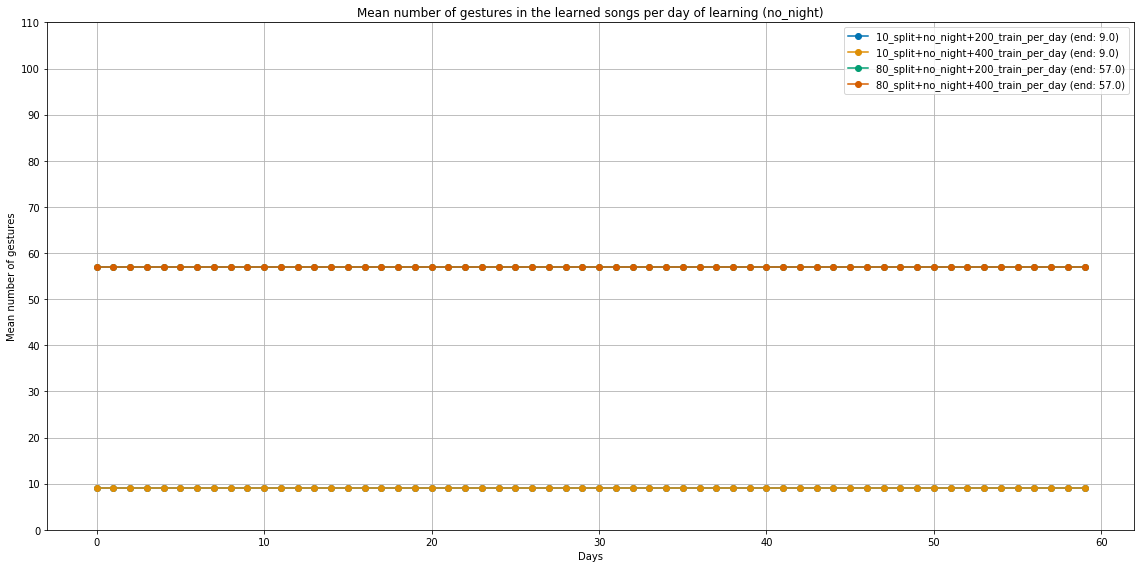

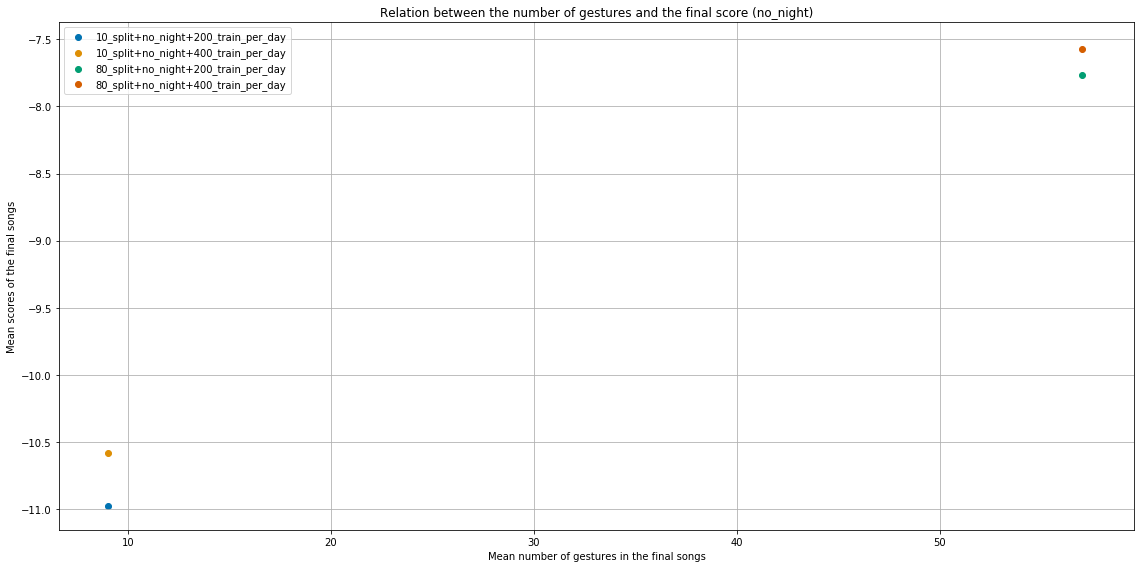

In [9]:
cluster_sim_path = res_path + "no_night_180910_165800/"
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores, final_scores, mean_nb_gest, label_names = tup
title = "no_night"
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# nlm_diversity_7_180903_151131

In [7]:
# cluster_sim_path = res_path + 'nlm_diversity_7_180903_151131/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# mean_scores, final_scores, mean_nb_gest, label_names = tup
# title = "diversity"
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# long_grid_div_th_180821_183837

### longer simulation, with the new mutations and a different deviation

- 10 seeds
- 60 days
- div_th: 500, 1000, 1500, 2000, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4500, 5000, 5500, 6000
- different deviation
- Mutation probabilities:
	- P(delete) = 0.1
	- P(split) = 0.1
	- P(move) = 0.75
	- P(nothing) = 0.05
- day scores data available!

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_grid_div_th+2500_diversity_th', 'long_grid_div_th+2750_diversity_th', 'long_grid_div_th+3000_diversity_th', 'long_grid_div_th+3250_diversity_th', 'long_grid_div_th+3500_diversity_th', 'long_grid_div_th+3750_diversity_th', 'long_grid_div_th+4000_diversity_th', 'long_grid_div_th+4500_diversity_th', 'long_grid_div_th+5000_diversity_th', 'long_grid_div_th+5500_diversity_th']
number of simulations: 10
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


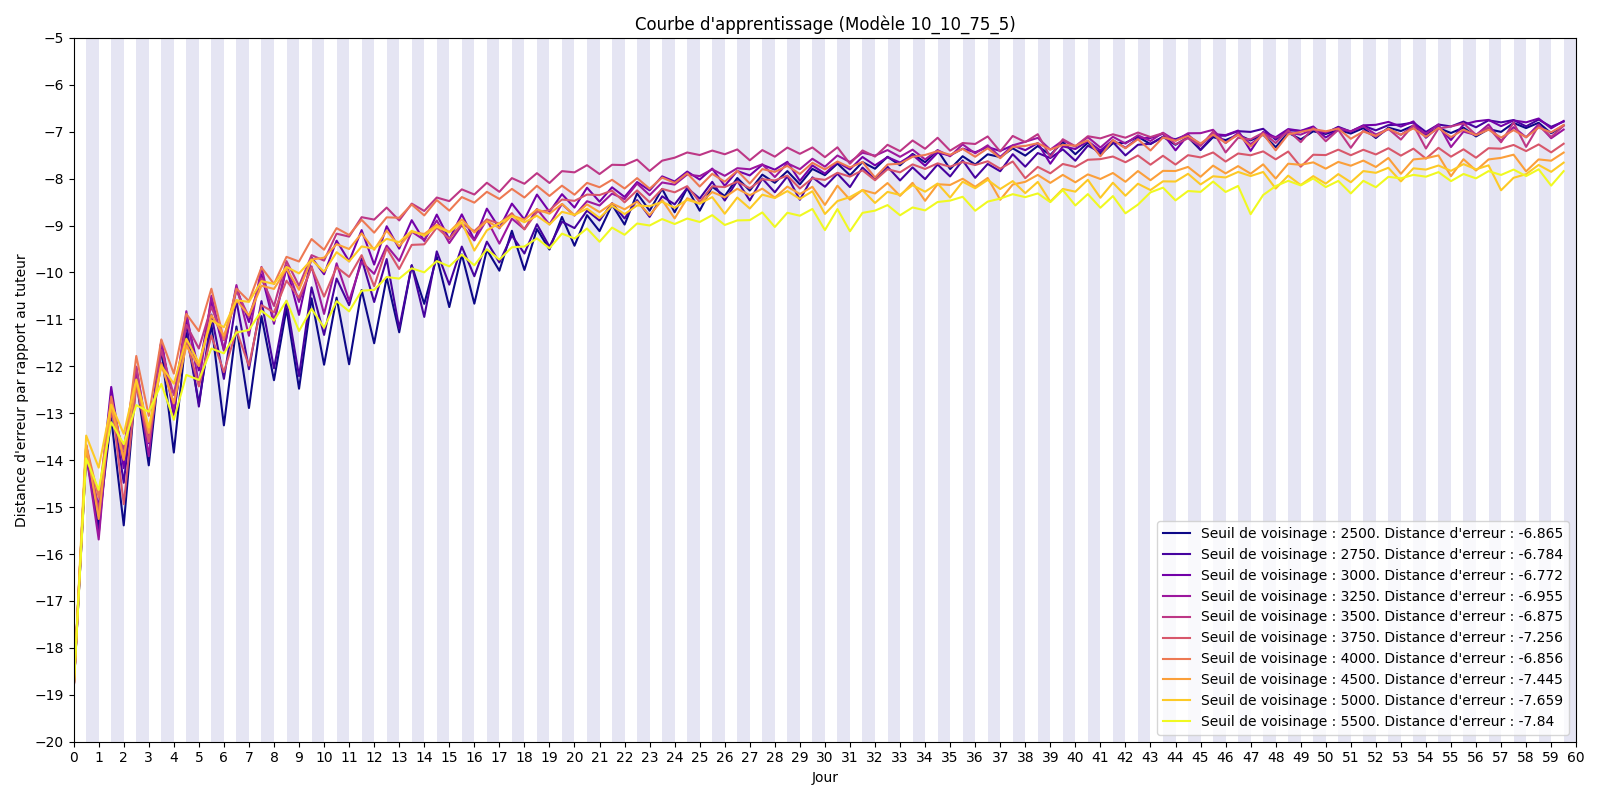

In [19]:
cluster_sim_path = res_path + 'long_grid_div_th_180821_183837/'
l_div_th = ['2500', '2750', '3000', '3250', '3500', '3750', 
            '4000', '4500', '5000', '5500']  # without the bad firsts, without the last one
# l_div_th = ['2750', '3000', '3250', '3750',
#             '4500', '5000', '5500']  # the flattering one
param_filter = [l_div_th]
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores, final_scores, mean_nb_gest, label_names = tup
title = "Modèle 10_10_75_5"
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# long_grid_div_th_180816_120049

### longer simulation, with the new mutations and a different deviation

- 10 seeds
- 60 days
- div_th: 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
- different deviation
- Mutation probabilities:
	- P(delete) = 0.25
	- P(split) = 0.25
	- P(move) = 0.25
	- P(nothing) = 0.25

In [16]:
# cluster_sim_path = res_path + 'long_grid_div_th_180816_120049/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# mean_scores, final_scores, mean_nb_gest, label_names = tup
# title = "25_25_25_25 new dev & long"
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# grid_div_th_180813_213247 

### plus results from grid_div_th_180814_201731

- Possible div_th: 500, 1000, 1500, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4500, 5000, 5500, 6000
- P(delete) = 0.1
- P(split) = 0.1
- P(move) = 0.75
- P(nothing) = 0.05

In [15]:
# cluster_sim_path = res_path + 'grid_div_th_180813_213247/'
# l_div_th = ['2750', '3000', '3250', '3500', '3750', 
#             '4000', '4500', '5000', '5500', '6000']
# param_filter = [l_div_th]
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# title = "10_10_75_5"
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# grid_div_th_180803_023956

### Simulation testing different types of diversity_threshold, using the new types of mutation (delete, split, move, nothing)
- possible div_th: 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
- P(delete) = 0.25
- P(split) = 0.25
- P(move) = 0.25
- P(nothing) = 0.25

In [12]:
# cluster_sim_path = res_path + 'grid_div_th_180803_023956/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# title = ("25_25_25_25")
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

Rq : Les résultats semblent décorrelés, mais la range du nombre de geste est faible

# nlm_div_th_test_180713_173751

### Simulation testing different values of diversity_threshold

Aggregation of multiple simulations with a lot of different diversity_threshold values

In [11]:
# """
# Possible diversity_threshold values:
# 100, 250, 500, 750, 
# 1000, 1250, 1500, 1750, 1875,
# 2000, 2250, 2500, 2750, 
# 3000, 3500, 4000, 5000
# """

# cluster_sim_path = res_path + 'nlm_div_th_test_180713_173751/'
# l_div_th = ['1500', '1750', '1875', '2000', '2250', '2500', '3000', '3500', '4000', '5000']
# # l_div_th = ['+500_', '1000', '2000', '3000', '4000', '5000']  #'+500_' and not '500' to avoid the 1500, 2500, etc... values
# param_filter = [['0p_1rms'],
#                 l_div_th]
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse values using data from 1 simulation --
# sim_name = '+'.join([seeds[0], sims[0]])
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # day morning and day evening

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# title = "previous mutation"
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names, title)

# Both dev_test simulations

- dev_test_180717_115457
- dev_test_180802_225322 (with new type of mutations)
    - P(delete) = 0.25
    - P(split) = 0.25
    - P(move) = 0.25
    - P(nothing) = 0.25

In [10]:
# # old mutation version
# cluster_sim_path = res_path + 'dev_test_180717_115457/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])

# # new mutation version
# cluster_sim_path = res_path + 'dev_test_180802_225322/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# mean_scores_muta, final_scores_muta, mean_nb_gest_muta, label_names_muta = tup
# label_names_muta = [elt+"_muta" for elt in label_names_muta]

# mean_scores = np.concatenate((mean_scores, mean_scores_muta))
# final_scores = np.concatenate((final_scores, final_scores_muta))
# mean_nb_gest = np.concatenate((mean_nb_gest, mean_nb_gest_muta))
# label_names = label_names + label_names_muta
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'])

# dev_test_180717_115457

### Simulation testing different kinds of dev parameters

In [8]:
# cluster_sim_path = res_path + 'dev_test_180717_115457/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'])

# dev_test_180802_225322

### Simulation testing different kinds of deviation parameters, using the new types of mutation (delete, split, move, nothing)
- P(delete) = 0.25
- P(split) = 0.25
- P(move) = 0.25
- P(nothing) = 0.25

In [9]:
# cluster_sim_path = res_path + 'dev_test_180802_225322/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'])

# dlm_nlm_equilibrium_180807_173045

### Simulation testing parameters linked with the day algorithm and the night algorithm
- Mutation probabilites:
    - P(delete) = 0.25
    - P(split) = 0.25
    - P(move) = 0.25
    - P(nothing) = 0.25
- Day:
    - train_per_day
    - iter_per_train
- Night:
    - night_concurrent
    - replay

In [18]:
# cluster_sim_path = res_path + 'dlm_nlm_equilibrium_180807_173045/'
# param_filter = [['100_trainings'], ['20_iter'],['10_night_conc', '20_night_conc'],['100_replay', '200_replay']]
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# mean_scores, final_scores, mean_nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'])
# plot_corr_nb_gest_score(mean_nb_gest, final_scores, label_names)

# pitch_rms_test_180712_103336

(old simulation)

Test the utility of the pitch and / or the rms feature in the score calculation

In [19]:
# cluster_sim_path = res_path + 'pitch_rms_test_180712_103336/'
# param_filter = [['mutate_microbial_diversity_uniform']]
# aggregated_results(cluster_sim_path, param_filter=param_filter)